<a href="https://colab.research.google.com/github/Rahul-71/BackOrderPrediction/blob/feature_TRIAL/BackOrder_Prediction_iNeuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from warnings import filterwarnings
filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

<h2> Dataset

In the Train dataset we are provided with 23 columns(Features) of data.
* Sku(Stock Keeping unit) : The product id — Unique for each row so can be ignored
* National_inv : The present inventory level of the product
* Lead_time : Transit time of the product
* In_transit_qty : The amount of product in transit
* Forecast_3_month , Forecast_6_month , Forecast_9_month : Forecast of the sales of the product for coming 3 , 6 and 9 months respectively
* Sales_1_month , sales_3_month ,sales_6_month , sales_9_month : Actual sales of the product in last 1 , 3 ,6 and 9 months respectively
* Min_bank : Minimum amount of stock recommended
* Potential_issue : Any problem identified in the product/part
* Pieces_past_due: Amount of parts of the product overdue if any
* Perf_6_month_avg , perf_12_month_avg : Product performance over past 6 and 12 months respectively
* Local_bo_qty : Amount of stock overdue
* Deck_risk , oe_constraint, ppap_risk, stop_auto_buy, rev_stop : Different Flags (Yes or No) set for the product
* Went_on_backorder : Target variable

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df = pd.read_csv('/content/drive/MyDrive/BackOrder_Internship/Kaggle_Training_Dataset_v2.csv')

<h2> Data Exploration

In [14]:
df.shape

(1687861, 23)

In [15]:
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [17]:
df.tail()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Last rows contains all the null values, it doesn't add any value to the dataset. So, dropping this row from the dataset.

In [18]:
df.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


* By this we can see that, numerical values are of different scales, which is not good for any machine learning algorithms. So, need to perform standard scaling before applying any algorithm.

In [19]:
df.describe(include=['O'])

,sku,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1687861,1687860,1687860,1687860,1687860,1687860,1687860,1687860
unique,1687861,2,2,2,2,2,2,2
top,1565619,No,No,No,No,Yes,No,No
freq,1,1686953,1300377,1687615,1484026,1626774,1687129,1676567


* `sku` has all unique values, so it can be removed. Since it can be any id for rows
* all other non-numerical columns has 2 distinct values(YES/NO), which can be binary encoded (ie. can be converted into 1 & 0 )

In [20]:
df.isna().sum()/df.shape[0] * 100

sku                  0.000000
national_inv         0.000059
lead_time            5.977625
in_transit_qty       0.000059
forecast_3_month     0.000059
forecast_6_month     0.000059
forecast_9_month     0.000059
sales_1_month        0.000059
sales_3_month        0.000059
sales_6_month        0.000059
sales_9_month        0.000059
min_bank             0.000059
potential_issue      0.000059
pieces_past_due      0.000059
perf_6_month_avg     0.000059
perf_12_month_avg    0.000059
local_bo_qty         0.000059
deck_risk            0.000059
oe_constraint        0.000059
ppap_risk            0.000059
stop_auto_buy        0.000059
rev_stop             0.000059
went_on_backorder    0.000059
dtype: float64

* Around 6% of the `lead_time` values are `null`, which can be imputed by the mean of `lead_time` or by replacing `null` from 0

<h3> DATA CLEANING

In [21]:
# removing the last row of the dataset
df = df.iloc[:-1,:]

In [22]:
# removing the sku feature, since its not adding any value to the dataset
df.drop(['sku'],axis=1, inplace=True)
df.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [23]:
catg_features = df.select_dtypes(include=['O']).columns

In [24]:
df[catg_features] = df[catg_features].applymap(lambda x: 0 if x=='No' else 1)

In [25]:
df.fillna(value=df.lead_time.median(), inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687860 entries, 0 to 1687859
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1687860 non-null  float64
 1   lead_time          1687860 non-null  float64
 2   in_transit_qty     1687860 non-null  float64
 3   forecast_3_month   1687860 non-null  float64
 4   forecast_6_month   1687860 non-null  float64
 5   forecast_9_month   1687860 non-null  float64
 6   sales_1_month      1687860 non-null  float64
 7   sales_3_month      1687860 non-null  float64
 8   sales_6_month      1687860 non-null  float64
 9   sales_9_month      1687860 non-null  float64
 10  min_bank           1687860 non-null  float64
 11  potential_issue    1687860 non-null  int64  
 12  pieces_past_due    1687860 non-null  float64
 13  perf_6_month_avg   1687860 non-null  float64
 14  perf_12_month_avg  1687860 non-null  float64
 15  local_bo_qty       1687860 non-n

<h2> Data Visualization 

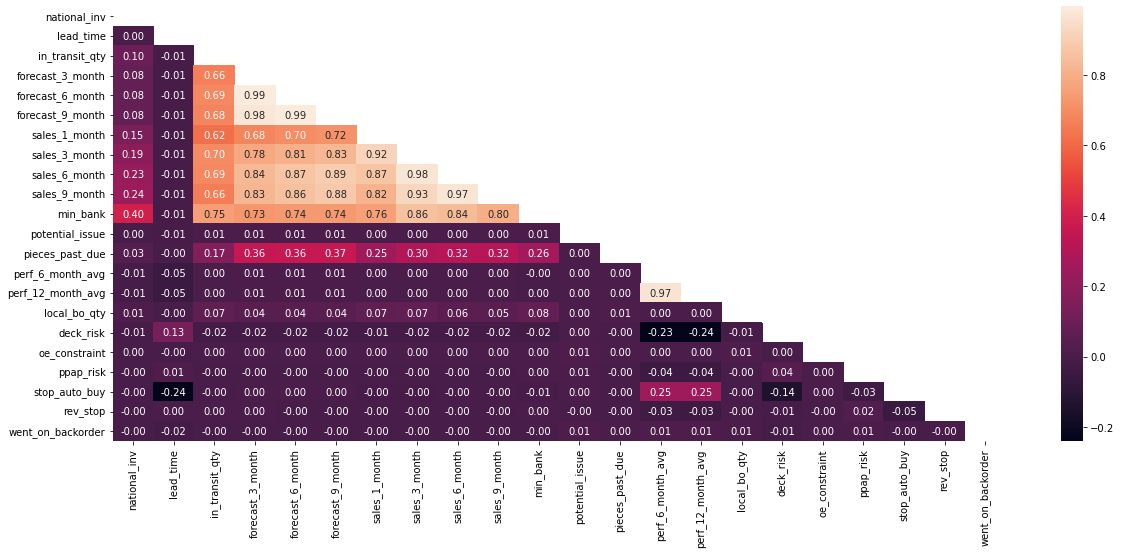

In [27]:
corr_matrix = df.corr()

plt.figure(figsize=(20,8))
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', mask = np.triu(corr_matrix))
plt.show()

`min_bank` & `in_transit_qty` are highly related to sales & forecast features

In [28]:
# removing target variable from the list ie. 'went_on_backorder'
num_features = list(set(df.columns) - set(catg_features))
catg_features = list(catg_features)

catg_features.remove('went_on_backorder')

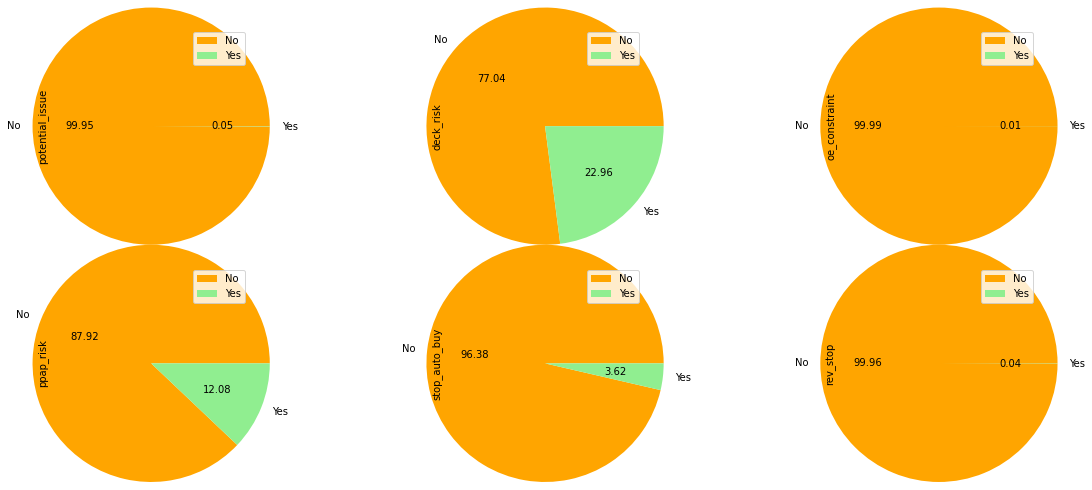

In [ ]:
# PIE CHART
plt.figure(figsize=(20,8))
for i,feat in enumerate(catg_features):
  plt.subplot(2,3,i+1)
  df[feat].value_counts().plot(kind='pie', autopct='%.2f', radius = 1.5, legend=True, colors=['orange','lightgreen'], labels=['No','Yes'])
plt.show()

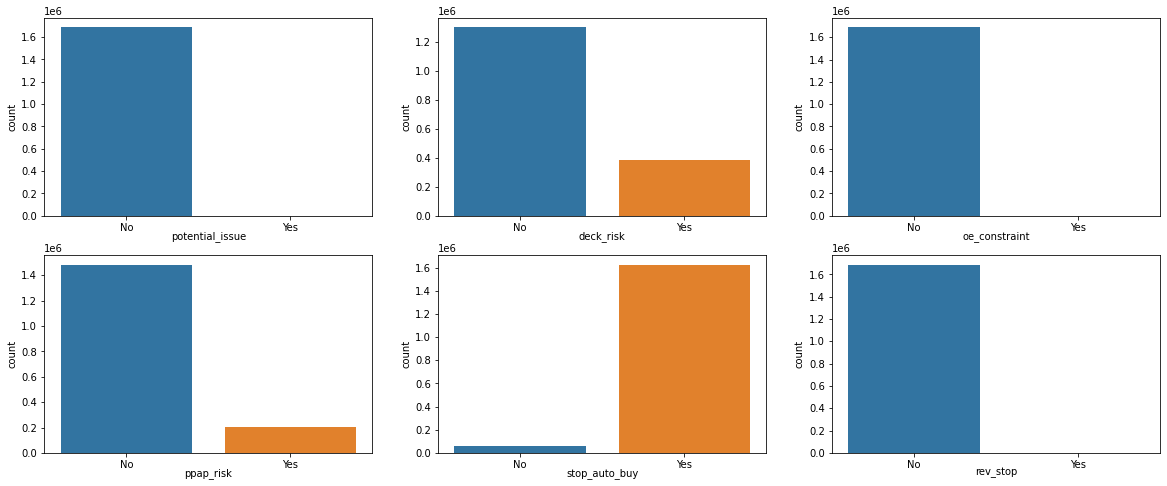

In [ ]:
# COUNT PLOT

plt.figure(figsize=(20,8))
for i,feat in enumerate(catg_features):
  plt.subplot(2,3,i+1)
  sns.countplot(df[feat])
  plt.xlabel(xlabel=feat,labelpad=-2)
  plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.show()

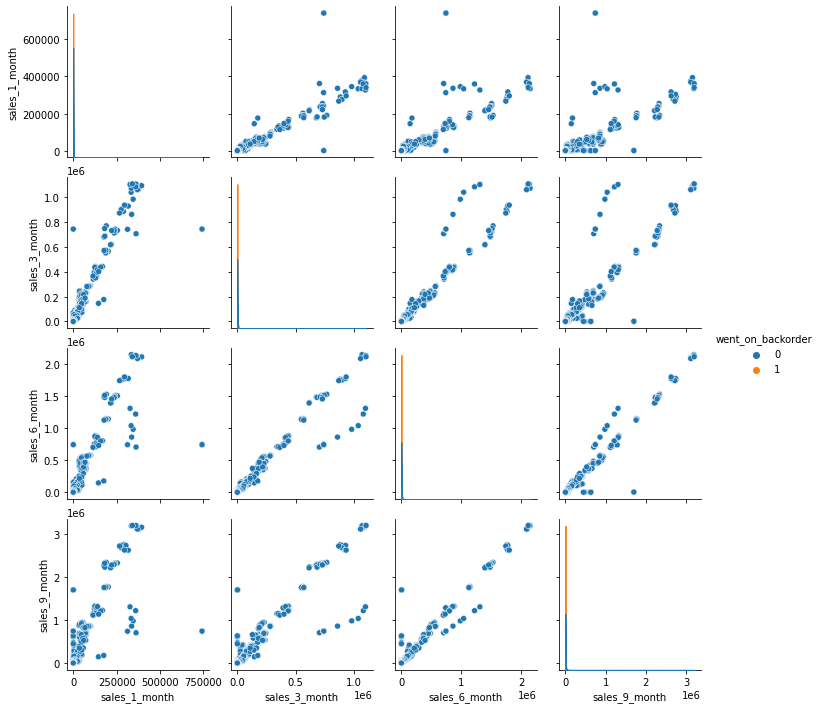

In [ ]:
# PAIR PLOT
sns.pairplot(data=df, hue='went_on_backorder', vars=['sales_1_month','sales_3_month', 'sales_6_month', 'sales_9_month'])
plt.show()

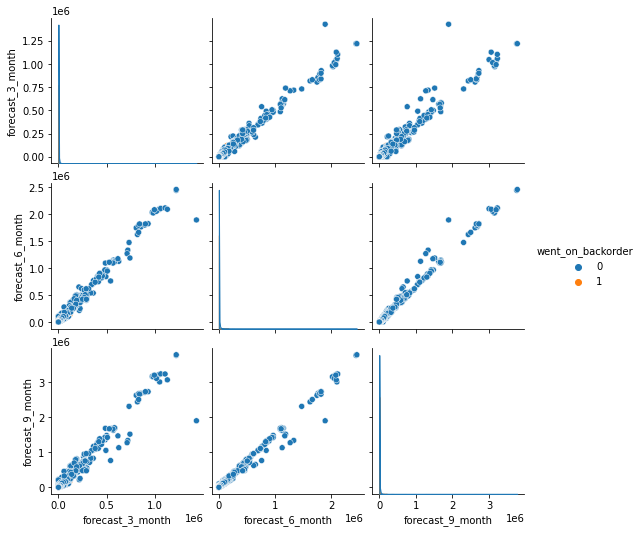

In [ ]:
forecast = ['forecast_3_month','forecast_6_month', 'forecast_9_month']
sns.pairplot(data=df, hue='went_on_backorder', vars=forecast)
plt.show()

This shows that the dataset possesses linear nature.
<br>
Linear algorithms will be the give out the better results

In [29]:
X = df.loc[: , df.columns!='went_on_backorder']
Y = df['went_on_backorder']

In [30]:
# splitting the data set into train & test data
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size=0.3, stratify=Y, shuffle=True, random_state = 154)

Will apply few types of classification algorithms
- Logistic Regression
- k-Nearest Neighbors  (*works horrible with large dataset*)
- Decision Trees
- Support Vector Machine  (*works horrible with large dataset*)
- Naive Bayes

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)
x_te = scaler.fit_transform(x_te)

In [83]:
models = dict()

In [84]:
#lets apply the logistic regression
from time import time
from sklearn.linear_model import LogisticRegression

s = time()
lr = LogisticRegression()
# lr = LogisticRegression(class_weight='balanced')
lr.fit(x_tr, y_tr)
lr_time = str(round(time() - s,3)) + " sec"
print("Accuracy of Logistic Regression on training set : ", lr.score(x_tr, y_tr))
print("Accuracy of Logistic Regression on testing set : ", lr.score(x_te, y_te))

print("-"*60)
print(f"Time taken for Logistic Regression : {lr_time}")
models.update({"Logistic Regression":(lr.score(x_tr, y_tr), lr.score(x_te, y_te), lr_time)})

Accuracy of Logistic Regression on training set :  0.9932992072802247
Accuracy of Logistic Regression on testing set :  0.9932952575055594
------------------------------------------------------------
Time taken for Logistic Regression : 25.037 sec


In [85]:
# lets apply Decision Trees

from sklearn.tree import DecisionTreeClassifier as DTC
s = time()
dt = DTC()
# dt = DTC(class_weight='balanced')
dt.fit(x_tr, y_tr)
dt_time = str(round(time() - s,3)) + " sec"
print("Accuracy of Decision Tree Classifier on training set : ", dt.score(x_tr, y_tr))
print("Accuracy of Decision Tree Classifier on testing set : ", dt.score(x_te, y_te))

print("-"*60)
print(f"Time taken for Decision Tree Classifier : {dt_time}")
models.update({"Decision Tree Classifier":(dt.score(x_tr, y_tr), dt.score(x_te, y_te), dt_time)})

Accuracy of Decision Tree Classifier on training set :  0.9995996621249901
Accuracy of Decision Tree Classifier on testing set :  0.9917291718507459
------------------------------------------------------------
Time taken for Decision Tree Classifier : 16.132 sec


In [86]:
# lets apply Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

s = time()
gnb = GaussianNB()
gnb.fit(x_tr, y_tr)
gnb_time = str(round(time() - s,3)) + " sec"
print("Accuracy of Gaussian Naive Bayes on training set : ", gnb.score(x_tr, y_tr))
print("Accuracy of Gaussian Naive Bayes on testing set : ", gnb.score(x_te, y_te))

print("-"*60)
print(f"Time taken for Gaussian Naive Bayes : {gnb_time}")
models.update({"Gaussian Naive Bayes":(gnb.score(x_tr, y_tr), gnb.score(x_te, y_te), gnb_time)})

Accuracy of Gaussian Naive Bayes on training set :  0.05619965095277029
Accuracy of Gaussian Naive Bayes on testing set :  0.134602395933312
------------------------------------------------------------
Time taken for Gaussian Naive Bayes : 0.493 sec


In [87]:
# lets apply Linear Discrimant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
s = time()
lda = LinearDiscriminantAnalysis()
lda.fit(x_tr, y_tr)
lda_time = str(round(time() - s,3)) + " sec"
print("Accuracy of LDA classifier on training set : ", lda.score(x_tr, y_tr))
print("Accuracy of LDA classifier on testing set : ", lda.score(x_te, y_te))

print("-"*60)
print(f"Time taken for LDA classifier : {lda_time}")
models.update({"LDA classifier":(lda.score(x_tr, y_tr), lda.score(x_te, y_te), lda_time)})

Accuracy of LDA classifier on training set :  0.9927719123623997
Accuracy of LDA classifier on testing set :  0.9927363643904116
------------------------------------------------------------
Time taken for LDA classifier : 4.339 sec


In [88]:
print("Summarazing the classification result:")
from prettytable import PrettyTable
table = PrettyTable(field_names=['S.No.', 'Algorithm', 'Train Score', 'Test Score', 'Time Taken'])

for i, mo in enumerate(models.keys()):
  val = models.get(mo)
  table.add_row([i+1, mo, val[0], val[1], val[2]])
print(table)



Summarazing the classification result:
+-------+--------------------------+---------------------+--------------------+------------+
| S.No. |        Algorithm         |     Train Score     |     Test Score     | Time Taken |
+-------+--------------------------+---------------------+--------------------+------------+
|   1   |   Logistic Regression    |  0.9932992072802247 | 0.9932952575055594 | 25.037 sec |
|   2   | Decision Tree Classifier |  0.9995996621249901 | 0.9917291718507459 | 16.132 sec |
|   3   |   Gaussian Naive Bayes   | 0.05619965095277029 | 0.134602395933312  | 0.493 sec  |
|   4   |      LDA classifier      |  0.9927719123623997 | 0.9927363643904116 | 4.339 sec  |
+-------+--------------------------+---------------------+--------------------+------------+


Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


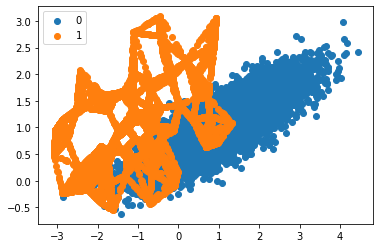

In [22]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

before SMOTE :  Counter({0: 1173597, 1: 7905})
after SMOTE :  Counter({0: 586795, 1: 117359})


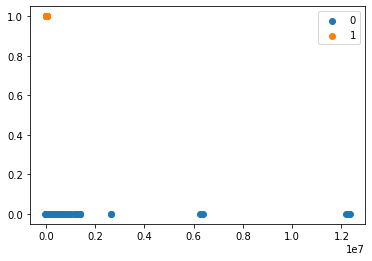

In [74]:
# Oversample with SMOTE and random undersample for imbalanced dataset
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# from matplotlib import pyplot
# from numpy import where
# # define dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
# 	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# # summarize class distribution
# counter = Counter(y)
# print(counter)
# # define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
A, B = pipeline.fit_resample(x_tr, y_tr)
# summarize the new class distribution
counter = Counter(y_tr)
print("before SMOTE : ",counter)
counter = Counter(B)
print("after SMOTE : ",counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(B == label)[0]
	pyplot.scatter(A[row_ix, 0], B[row_ix], label=str(label))
pyplot.legend()
pyplot.show()

In [66]:
counter =Counter(B)
for labels, _ in counter.items():
  row_ix = where(B==labels)[0]
  print(row_ix)

[     0      1      2 ... 782393 782394 782395]
[ 782396  782397  782398 ... 1251831 1251832 1251833]


In [65]:
where(B==1)

(array([ 782396,  782397,  782398, ..., 1251831, 1251832, 1251833]),)

In [54]:
# plt.scatter([A,B],heu=B)
sns.scatterplot([A,B], hue=B)
plt.show()

ValueError: ignored

AttributeError: ignored

In [53]:
1251834*21

26288514